In [7]:
import torch
import torch.nn as nn
import torch.optim as optim # algorithm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error #
import yfinance as yf # 
from torch.utils.data import DataLoader, TensorDataset #

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [8]:
class StockRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(StockRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through RNN
        out, _ = self.rnn(x, h0)
        
        # Get the last output
        out = self.fc(out[:, -1, :])
        
        return out

In [9]:
class StockDataset:
    def __init__(self, symbol='AAPL', period='2y', sequence_length=60):
        self.symbol = symbol
        self.period = period
        self.sequence_length = sequence_length
        self.scaler = MinMaxScaler()
        
    def download_data(self):
        """Download stock data using yfinance"""
        print(f"Downloading {self.symbol} data...")
        stock = yf.Ticker(self.symbol)
        data = stock.history(period=self.period)
        
        # Use closing prices
        self.raw_data = data['Close'].values.reshape(-1, 1)
        print(f"Downloaded {len(self.raw_data)} data points")
        
        return data
    
    def prepare_data(self, train_ratio=0.8):
        """Prepare data for training"""
        # Scale the data
        scaled_data = self.scaler.fit_transform(self.raw_data)
        
        # Create sequences
        X, y = [], []
        for i in range(self.sequence_length, len(scaled_data)):
            X.append(scaled_data[i-self.sequence_length:i]) # [10, 11, 13]
            y.append(scaled_data[i]) #                         12
        
        X, y = np.array(X), np.array(y)
        
        # Split into train and test
        train_size = int(len(X) * train_ratio)
        
        self.X_train = torch.FloatTensor(X[:train_size])
        self.y_train = torch.FloatTensor(y[:train_size])
        self.X_test = torch.FloatTensor(X[train_size:])
        self.y_test = torch.FloatTensor(y[train_size:])
        
        print(f"Training samples: {len(self.X_train)}")
        print(f"Test samples: {len(self.X_test)}")
        
        return self.X_train, self.y_train, self.X_test, self.y_test


In [10]:
StockDataset

__main__.StockDataset

In [16]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, learning_rate=0.001):
    """Train the RNN model"""
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #model.to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Training history
    train_losses = []
    test_losses = []
    
    print(f"Training on {device}")
    print("-" * 50)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad() #
            
            outputs = model(batch_X) # this is my y_hat
            loss = criterion(outputs, batch_y) # batch_y is my y_true 
            
            optimizer.step()
            loss.backward() # backpropogation and go update my parameters while you compute them in tihs step. outputs = model(batch_X) # this is my y_hat
            
            
            total_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            #X_test_device = X_test.to(device)
            #y_test_device = y_test.to(device)
            test_outputs = model(X_test_device) # y_pred on test data
            test_loss = criterion(test_outputs, y_test_device).item() # loss on test data, just to visualise 
            test_losses.append(test_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}')
    
    return train_losses, test_losses


In [17]:
def evaluate_model(model, X_test, y_test, scaler, dataset):
    """Evaluate the model and create visualizations"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    with torch.no_grad():
        X_test_device = X_test.to(device)
        predictions = model(X_test_device).cpu().numpy()
        actual = y_test.numpy()
        
        # Inverse transform to get actual prices
        predictions_scaled = scaler.inverse_transform(predictions)
        actual_scaled = scaler.inverse_transform(actual)
        
        # Calculate metrics
        mse = mean_squared_error(actual_scaled, predictions_scaled) # MSE --> coming out of sum of squared resiudals 
        mae = mean_absolute_error(actual_scaled, predictions_scaled) # absolut
        rmse = np.sqrt(mse) # square root of MSE
        
        print(f"\nModel Performance:")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAE: ${mae:.2f}")
        print(f"MSE: {mse:.2f}")
        
        # Create visualizations
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Training history
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Predictions vs Actual
        plt.subplot(1, 2, 2)
        plt.plot(actual_scaled[-200:], label='Actual', alpha=0.7)
        plt.plot(predictions_scaled[-200:], label='Predicted', alpha=0.7)
        plt.title(f'{dataset.symbol} Price Prediction (Last 200 days)')
        plt.xlabel('Time')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return predictions_scaled, actual_scaled


=== Simple RNN for Stock Price Prediction ===
Stock: AAPL
Sequence Length: 3
Hidden Size: 64
Layers: 2
Downloaded 503 data points
Training samples: 400
Test samples: 100

Model Architecture:
StockRNN(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 12,673

Starting training...
Training on cpu
--------------------------------------------------
Epoch [10/100], Train Loss: 0.002369, Test Loss: 0.006054
Epoch [20/100], Train Loss: 0.002183, Test Loss: 0.005771
Epoch [30/100], Train Loss: 0.001987, Test Loss: 0.005539
Epoch [40/100], Train Loss: 0.001909, Test Loss: 0.004770
Epoch [50/100], Train Loss: 0.001657, Test Loss: 0.004295
Epoch [60/100], Train Loss: 0.001552, Test Loss: 0.004230
Epoch [70/100], Train Loss: 0.001457, Test Loss: 0.003723
Epoch [80/100], Train Loss: 0.001534, Test Loss: 0.004500
Epoch [90/100], Train Loss: 0.001381, Test Loss: 0.003378
Epoch [100/100], Train Loss: 0.001264,

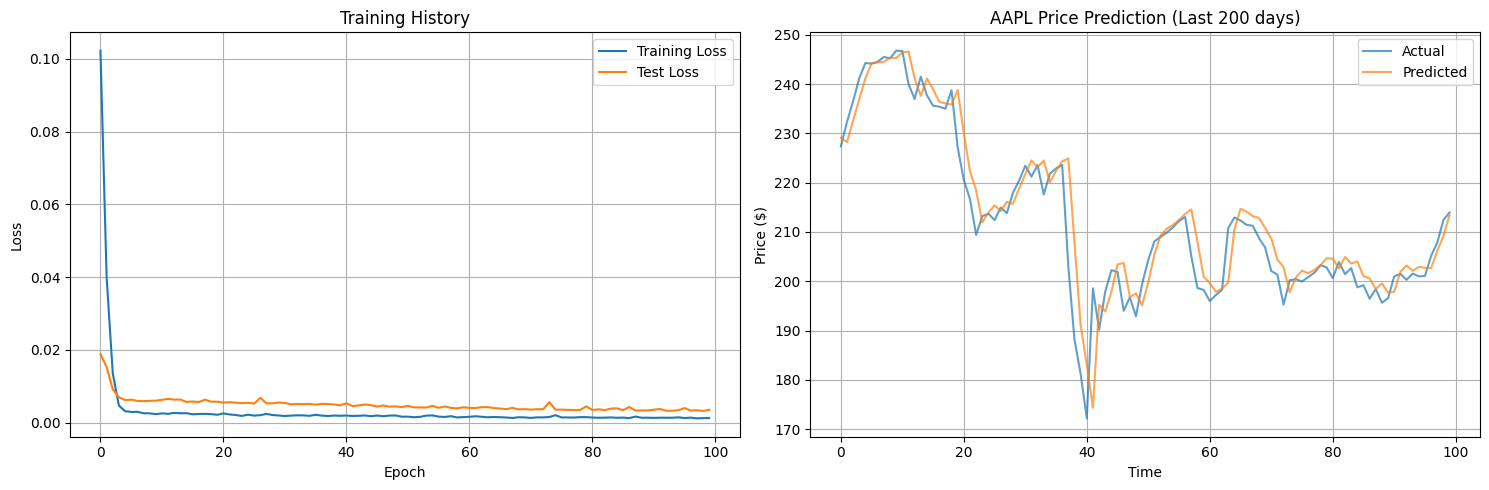


Model saved as 'AAPL_rnn_model.pth'

=== Training Complete ===
Key learnings about RNNs:
1. RNNs process sequences step by step
2. Hidden states carry information across time steps
3. Sequence length affects how far back the model can 'remember'
4. Scaling data is crucial for neural network performance
5. Stock prediction is challenging due to market complexity!


In [15]:

# Main execution
if __name__ == "__main__":
    # Parameters
    STOCK_SYMBOL = 'AAPL'  # Change this to any stock symbol
    SEQUENCE_LENGTH = 3   # Number of past days to look at 
    HIDDEN_SIZE = 64      # RNN hidden size
    NUM_LAYERS = 2        # Number of RNN layers
    EPOCHS = 100          # Training epochs
    BATCH_SIZE = 32       # Batch size only and only needed when the data is hugee (Millions of datapoints)
    LEARNING_RATE = 0.001 # Learning rate
    
    print("=== Simple RNN for Stock Price Prediction ===")
    print(f"Stock: {STOCK_SYMBOL}")
    print(f"Sequence Length: {SEQUENCE_LENGTH}")
    print(f"Hidden Size: {HIDDEN_SIZE}")
    print(f"Layers: {NUM_LAYERS}")
    print("=" * 50)
    
    # Step 1: Prepare data
    dataset = StockDataset(symbol=STOCK_SYMBOL, sequence_length=SEQUENCE_LENGTH)
    stock_data = dataset.download_data()
    X_train, y_train, X_test, y_test = dataset.prepare_data()
    
    # Step 2: Create model
    model = StockRNN(
        input_size=1,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        output_size=1
    )
    
    print(f"\nModel Architecture:")
    print(model)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Step 3: Train model
    print(f"\nStarting training...")
    train_losses, test_losses = train_model(
        model, X_train, y_train, X_test, y_test,
        epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE
    )
    
    # Step 4: Evaluate model
    print(f"\nEvaluating model...")
    predictions, actual = evaluate_model(model, X_test, y_test, dataset.scaler, dataset)
    
    # Step 5: Save model
    # torch.save(model.state_dict(), f'{STOCK_SYMBOL}_rnn_model.pth')
    print(f"\nModel saved as '{STOCK_SYMBOL}_rnn_model.pth'")
    
    print("\n=== Training Complete ===")
    print("Key learnings about RNNs:")
    print("1. RNNs process sequences step by step")
    print("2. Hidden states carry information across time steps")
    print("3. Sequence length affects how far back the model can 'remember'")
    print("4. Scaling data is crucial for neural network performance")
    print("5. Stock prediction is challenging due to market complexity!")